# Sklearn Example
This notebook showcases the scalecast wrapper around scikit-learn models. The following concepts are overviewed:

1. Modeling with MLR  
2. Regularization of linear models  
3. Ensemble Modeling with Random Forest, XGBoost, LightGBM, Bagging, and Stacking  
4. Model Benchmarking  
5. Results visualization  
6. Feature importance  

The data is available for download here: https://www.kaggle.com/datasets/bobnau/daily-website-visitors  
See the blog post: https://medium.com/towards-data-science/expand-your-time-series-arsenal-with-these-models-10c807d37558  

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from tqdm.notebook import tqdm

# sklearn imports for the bagging and stacking models
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

sns.set(rc={'figure.figsize':(12,8)})
pd.set_option('max_colwidth',500)
pd.set_option('display.max_rows',500)

In [2]:
def plot_test_export_summaries(f):
    """ exports the relevant statisitcal information and displays a plot of the test-set results for the last model run
    """
    f.plot_test_set(models=f.estimator,ci=True)
    plt.title(f'{f.estimator} test-set results',size=16)
    plt.show()
    return f.export('model_summaries',determine_best_by='TestSetMAPE')[
        [
            'ModelNickname',
            'HyperParams',
            'TestSetMAPE',
            'TestSetR2',
            'InSampleMAPE',
            'InSampleR2'
        ]
    ]

We will bring in the default grids from scalecast and tune some of our models this way. For others, we will create our own grids.

In [3]:
GridGenerator.get_example_grids()

In [4]:
data = pd.read_csv('daily-website-visitors.csv')
data.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582",1430,152
1,2,Monday,2,9/15/2014,"3,621","2,528",2297,231
2,3,Tuesday,3,9/16/2014,"3,698","2,630",2352,278
3,4,Wednesday,4,9/17/2014,"3,667","2,614",2327,287
4,5,Thursday,5,9/18/2014,"3,316","2,366",2130,236


In [5]:
data.shape

(2167, 8)

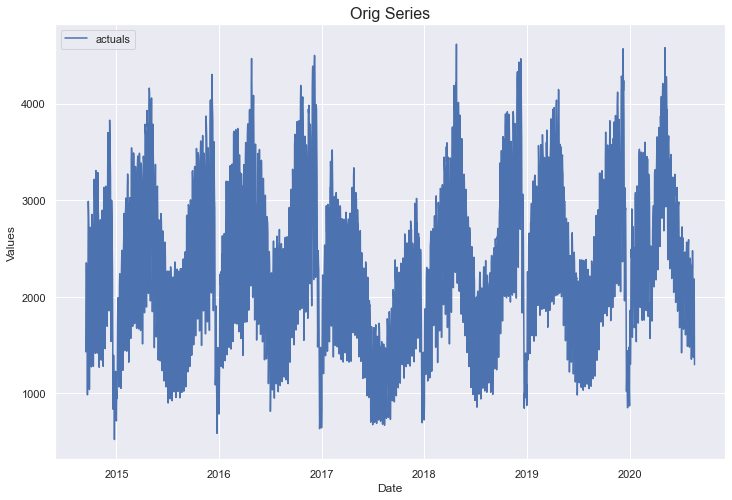

In [6]:
f=Forecaster(y=data['First.Time.Visits'],current_dates=data['Date'])
f.plot()
plt.title('Orig Series',size=16)
plt.show()

Not all models we will showcase come standard in scalecast, but we can easily add them by using the code below:

In [7]:
f.add_sklearn_estimator(Lasso,'lasso')
f.add_sklearn_estimator(Ridge,'ridge')
f.add_sklearn_estimator(BaggingRegressor,'bagging')
f.add_sklearn_estimator(StackingRegressor,'stacking')

For more EDA on this dataset, see the prophet example: https://scalecast-examples.readthedocs.io/en/latest/prophet/prophet.html#EDA

## Prepare Forecast
- 60-day forecast horizon
- 20% test split
- add time series regressors:
- 7 autoregressive terms  
  - 4 seasonal autoregressive terms spaced 7-periods apart  
  - month, quarter, week, and day of year with a fournier transformation  
  - dayofweek, leap year, and week as dummy variables  
  - year  

In [8]:
fcst_length = 60
f.generate_future_dates(fcst_length)
f.set_test_length(.2)
f.add_ar_terms(7)
f.add_AR_terms((4,7))
f.add_seasonal_regressors('month','quarter','week','dayofyear',raw=False,sincos=True)
f.add_seasonal_regressors('dayofweek','is_leap_year','week',raw=False,dummy=True,drop_first=True)
f.add_seasonal_regressors('year')
f

Forecaster(
    DateStartActuals=2014-09-14T00:00:00.000000000
    DateEndActuals=2020-08-19T00:00:00.000000000
    Freq=D
    N_actuals=2167
    ForecastLength=60
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR14', 'AR21', 'AR28', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 'weeksin', 'weekcos', 'dayofyearsin', 'dayofyearcos', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'is_leap_year_True', 'week_10', 'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_2', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_3', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_4', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_5', 'week_50', 'week_51', 'week_52', 'week_53', 'week_6', '

## MLR
- use default parameters (which means all input vars are scaled with a minmax scaler by default for all sklearn models)

In [9]:
f.set_estimator('mlr')
f.manual_forecast(dynamic_testing=fcst_length)

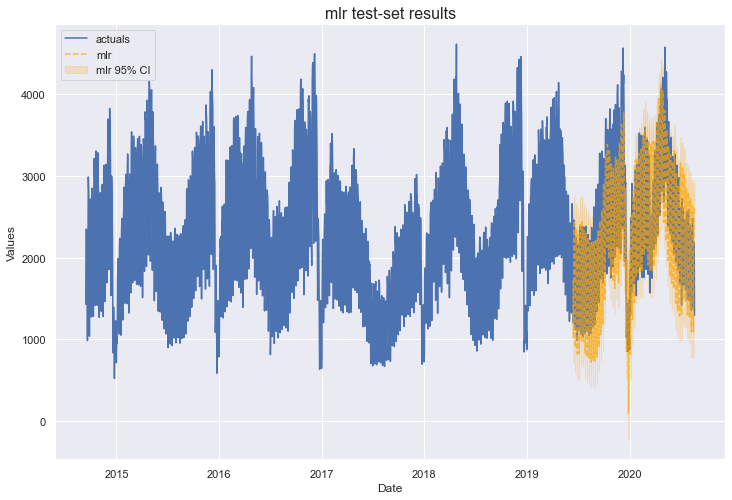

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,mlr,{},0.127293,0.770837,0.064186,0.953483


In [10]:
plot_test_export_summaries(f)

## Lasso
- tune alpha with 100 choices using 3-fold cross validation
- use 60-step forecast evaluation in each tuning and testing iteration

In [12]:
f.set_estimator('lasso')
lasso_grid = {'alpha':np.linspace(0,2,100)}
f.ingest_grid(lasso_grid)
f.cross_validate(dynamic_tuning=fcst_length,k=3)
f.auto_forecast(dynamic_testing=fcst_length)

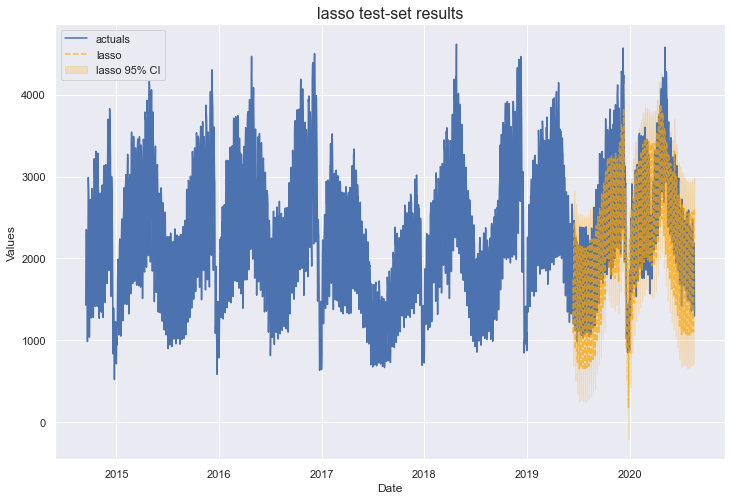

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,mlr,{},0.127293,0.770837,0.064186,0.953483
1,lasso,{'alpha': 0.26262626262626265},0.131272,0.774239,0.065229,0.952459


In [13]:
plot_test_export_summaries(f)

## Ridge
- tune alpha with the same grid used for lasso

In [14]:
f.set_estimator('ridge')
f.ingest_grid(lasso_grid)
f.cross_validate(dynamic_tuning=fcst_length,k=3)
f.auto_forecast(dynamic_testing=fcst_length)

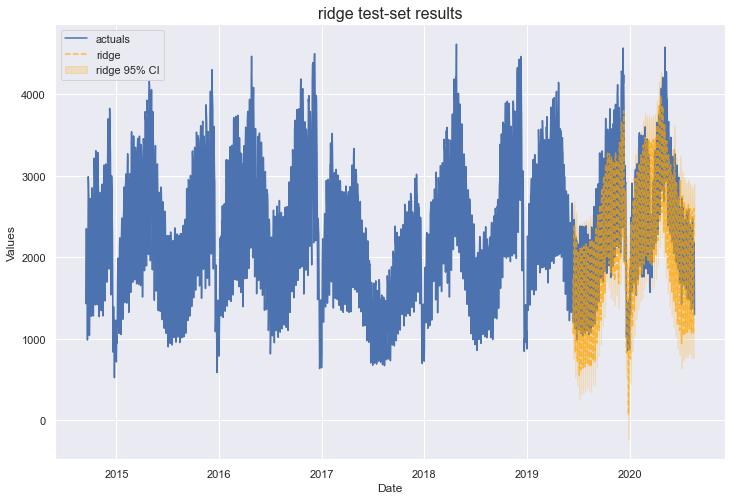

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,mlr,{},0.127293,0.770837,0.064186,0.953483
1,lasso,{'alpha': 0.26262626262626265},0.131272,0.774239,0.065229,0.952459
2,ridge,{'alpha': 0.16161616161616163},0.134394,0.769071,0.064234,0.953407


In [15]:
plot_test_export_summaries(f)

## Elasticnet

- this model mixes L1 and L2 regularization parameters
- its default grid is pretty good for finding the optimal alpha value

In [16]:
f.set_estimator('elasticnet')
f.cross_validate(dynamic_tuning=fcst_length,k=3)
f.auto_forecast(dynamic_testing=fcst_length)

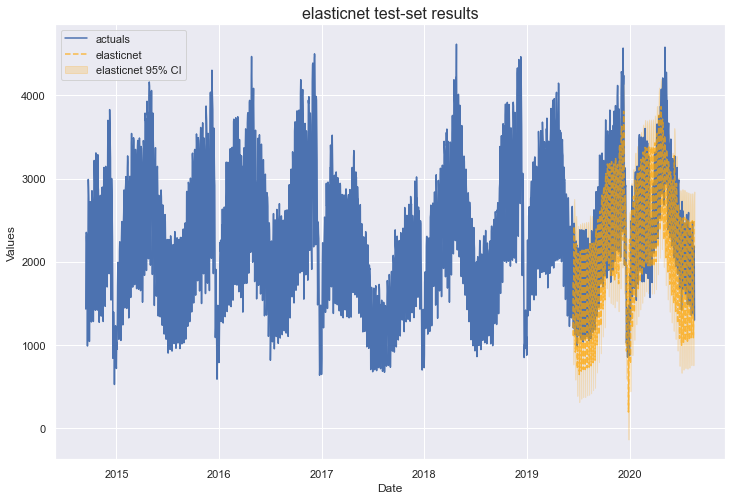

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,mlr,{},0.127293,0.770837,0.064186,0.953483
1,lasso,{'alpha': 0.26262626262626265},0.131272,0.774239,0.065229,0.952459
2,elasticnet,"{'alpha': 2, 'l1_ratio': 1}",0.132678,0.764336,0.065361,0.952031
3,ridge,{'alpha': 0.16161616161616163},0.134394,0.769071,0.064234,0.953407


In [17]:
plot_test_export_summaries(f)

## RF
- create a grid to tune Random Forest with more options than what is available in the default grids

In [18]:
f.set_estimator('rf')
rf_grid = {
    'max_depth':[2,3,4,5],
    'n_estimators':[100,200,500],
    'max_features':['auto','sqrt','log2'],
    'max_samples':[.75,.9,1],
}
f.ingest_grid(rf_grid)
f.cross_validate(dynamic_tuning=fcst_length,k=3)
f.auto_forecast(dynamic_testing=fcst_length)

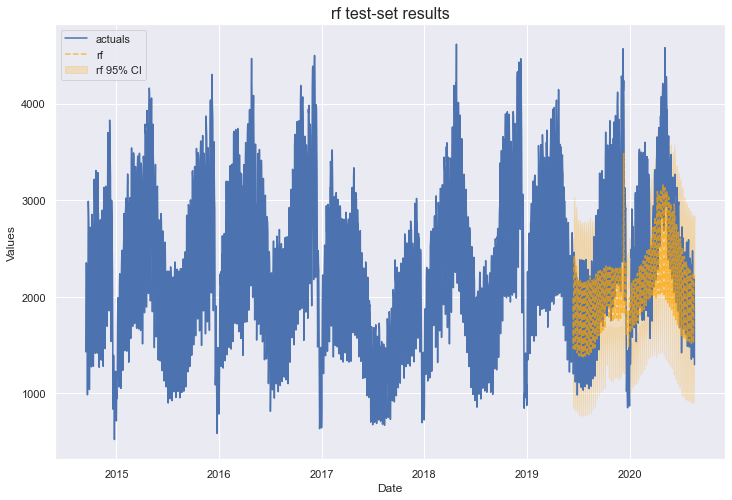

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,mlr,{},0.127293,0.770837,0.064186,0.953483
1,lasso,{'alpha': 0.26262626262626265},0.131272,0.774239,0.065229,0.952459
2,elasticnet,"{'alpha': 2, 'l1_ratio': 1}",0.132678,0.764336,0.065361,0.952031
3,ridge,{'alpha': 0.16161616161616163},0.134394,0.769071,0.064234,0.953407
4,rf,"{'max_depth': 5, 'n_estimators': 200, 'max_features': 'log2', 'max_samples': 0.75}",0.187206,0.276690,0.125122,0.853103


In [19]:
plot_test_export_summaries(f)

So far, both using a visual inspection and examing its test-set performance, Random Forest does worse than all others.

## XGBoost
- Build a grid to tune XGBoost

In [20]:
f.set_estimator('xgboost')
xgboost_grid = {
     'n_estimators':[150,200,250],
     'scale_pos_weight':[5,10],
     'learning_rate':[0.1,0.2],
     'gamma':[0,3,5], 
     'subsample':[0.8,0.9]
}
f.ingest_grid(xgboost_grid)
f.cross_validate(dynamic_tuning=fcst_length,k=3)
f.auto_forecast(dynamic_testing=fcst_length)

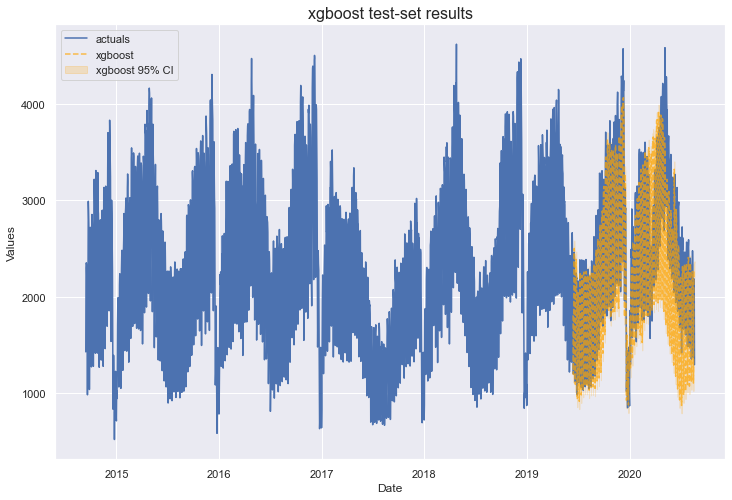

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,xgboost,"{'n_estimators': 200, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 5, 'subsample': 0.8}",0.113152,0.757755,0.015289,0.997268
1,mlr,{},0.127293,0.770837,0.064186,0.953483
2,lasso,{'alpha': 0.26262626262626265},0.131272,0.774239,0.065229,0.952459
3,elasticnet,"{'alpha': 2, 'l1_ratio': 1}",0.132678,0.764336,0.065361,0.952031
4,ridge,{'alpha': 0.16161616161616163},0.134394,0.769071,0.064234,0.953407
5,rf,"{'max_depth': 5, 'n_estimators': 200, 'max_features': 'log2', 'max_samples': 0.75}",0.187206,0.276690,0.125122,0.853103


In [21]:
plot_test_export_summaries(f)

This is our best model so far using the test MAPE as the metric to determine that by. It appears to be also be highly overfit.

## LightGBM
- Build a grid to tune LightGBM

In [22]:
f.set_estimator('lightgbm')
lightgbm_grid = {
    'n_estimators':[150,200,250],
    'boosting_type':['gbdt','dart','goss'],
    'max_depth':[1,2,3],
    'learning_rate':[0.001,0.01,0.1],
    'reg_alpha':np.linspace(0,1,5),
    'reg_lambda':np.linspace(0,1,5),
    'num_leaves':np.arange(5,50,5),
}
f.ingest_grid(lightgbm_grid)
f.limit_grid_size(100,random_seed=2)
f.cross_validate(dynamic_tuning=fcst_length,k=3)
f.auto_forecast(dynamic_testing=fcst_length)

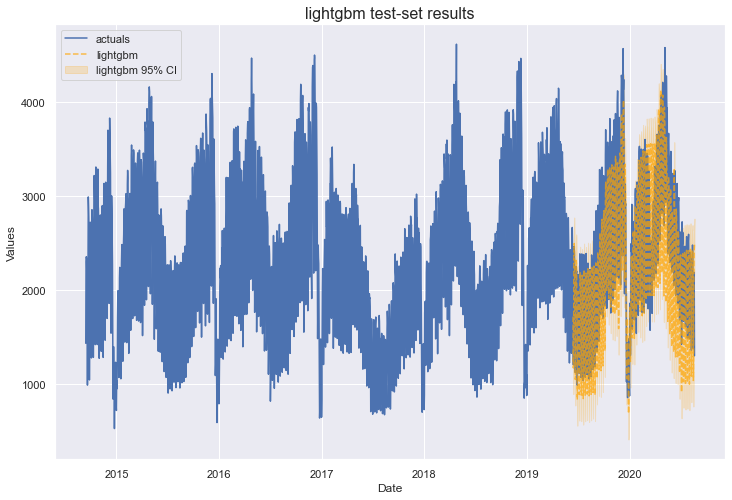

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,xgboost,"{'n_estimators': 200, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 5, 'subsample': 0.8}",0.113152,0.757755,0.015289,0.997268
1,mlr,{},0.127293,0.770837,0.064186,0.953483
2,lasso,{'alpha': 0.26262626262626265},0.131272,0.774239,0.065229,0.952459
3,elasticnet,"{'alpha': 2, 'l1_ratio': 1}",0.132678,0.764336,0.065361,0.952031
4,ridge,{'alpha': 0.16161616161616163},0.134394,0.769071,0.064234,0.953407
5,lightgbm,"{'n_estimators': 250, 'boosting_type': 'gbdt', 'max_depth': 3, 'learning_rate': 0.1, 'reg_alpha': 0, 'reg_lambda': 0.75, 'num_leaves': 20}",0.135379,0.740025,0.045360,0.974493
6,rf,"{'max_depth': 5, 'n_estimators': 200, 'max_features': 'log2', 'max_samples': 0.75}",0.187206,0.276690,0.125122,0.853103


In [23]:
plot_test_export_summaries(f)

## SGD
- Use the default Stochastic Gradient Descent grid

In [24]:
f.set_estimator('sgd')
f.cross_validate(dynamic_tuning=fcst_length,k=3)
f.auto_forecast(dynamic_testing=fcst_length)

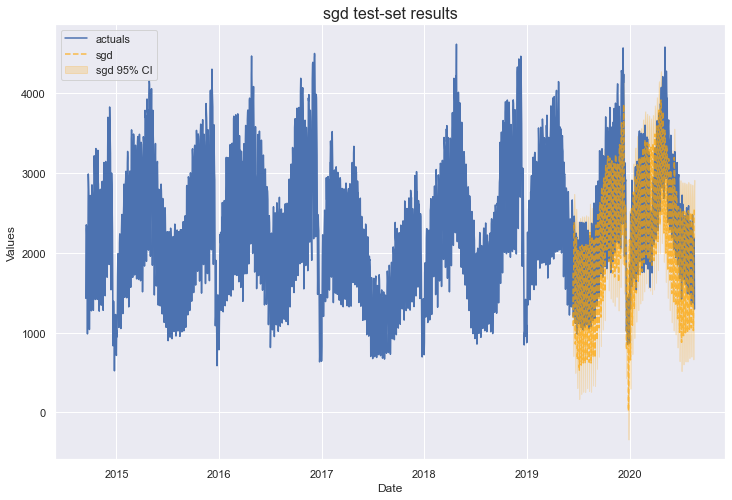

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,xgboost,"{'n_estimators': 200, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 5, 'subsample': 0.8}",0.113152,0.757755,0.015289,0.997268
1,mlr,{},0.127293,0.770837,0.064186,0.953483
2,lasso,{'alpha': 0.26262626262626265},0.131272,0.774239,0.065229,0.952459
3,elasticnet,"{'alpha': 2, 'l1_ratio': 1}",0.132678,0.764336,0.065361,0.952031
4,ridge,{'alpha': 0.16161616161616163},0.134394,0.769071,0.064234,0.953407
5,lightgbm,"{'n_estimators': 250, 'boosting_type': 'gbdt', 'max_depth': 3, 'learning_rate': 0.1, 'reg_alpha': 0, 'reg_lambda': 0.75, 'num_leaves': 20}",0.135379,0.740025,0.045360,0.974493
6,sgd,"{'penalty': 'elasticnet', 'l1_ratio': 0, 'learning_rate': 'invscaling'}",0.146777,0.730342,0.069495,0.945845
7,rf,"{'max_depth': 5, 'n_estimators': 200, 'max_features': 'log2', 'max_samples': 0.75}",0.187206,0.276690,0.125122,0.853103


In [25]:
plot_test_export_summaries(f)

## KNN
- Use the default K-nearest Neighbors grid

In [26]:
f.set_estimator('knn')
f.cross_validate(dynamic_tuning=fcst_length,k=3)
f.auto_forecast(dynamic_testing=fcst_length)

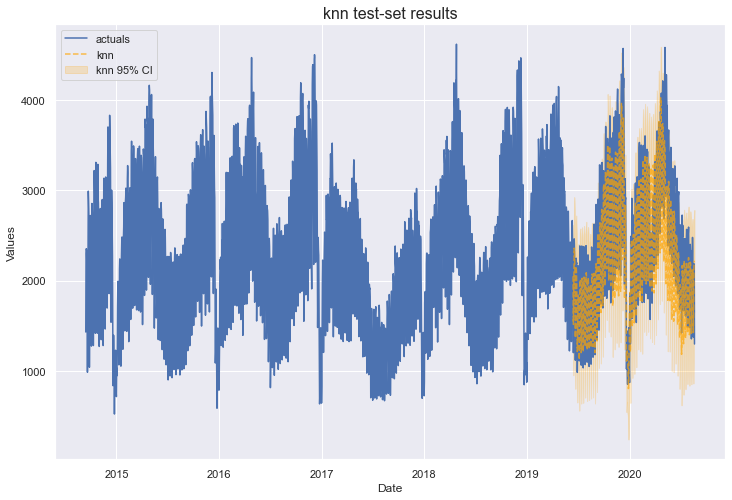

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,xgboost,"{'n_estimators': 200, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 5, 'subsample': 0.8}",0.113152,0.757755,0.015289,0.997268
1,knn,"{'n_neighbors': 6, 'weights': 'uniform'}",0.115727,0.779783,0.111621,0.871687
2,mlr,{},0.127293,0.770837,0.064186,0.953483
3,lasso,{'alpha': 0.26262626262626265},0.131272,0.774239,0.065229,0.952459
4,elasticnet,"{'alpha': 2, 'l1_ratio': 1}",0.132678,0.764336,0.065361,0.952031
5,ridge,{'alpha': 0.16161616161616163},0.134394,0.769071,0.064234,0.953407
6,lightgbm,"{'n_estimators': 250, 'boosting_type': 'gbdt', 'max_depth': 3, 'learning_rate': 0.1, 'reg_alpha': 0, 'reg_lambda': 0.75, 'num_leaves': 20}",0.135379,0.740025,0.045360,0.974493
7,sgd,"{'penalty': 'elasticnet', 'l1_ratio': 0, 'learning_rate': 'invscaling'}",0.146777,0.730342,0.069495,0.945845
8,rf,"{'max_depth': 5, 'n_estimators': 200, 'max_features': 'log2', 'max_samples': 0.75}",0.187206,0.276690,0.125122,0.853103


In [27]:
plot_test_export_summaries(f)

KNN is our most overfit model so far, but it fits the test-set pretty well.

## BaggingRegressor
- Like Random Forest is a bagging ensemble model using decision trees, we can use a bagging estimator that uses a three-layered mulit-level perceptron to see if the added complexity improves where the Random Forest couldn't

In [28]:
f.set_estimator('bagging')
f.manual_forecast(
    base_estimator = MLPRegressor(
        hidden_layer_sizes=(100,100,100)
        ,solver='lbfgs'
    ),
    max_samples = 0.9,
    max_features = 0.5,
    dynamic_testing=fcst_length,
)

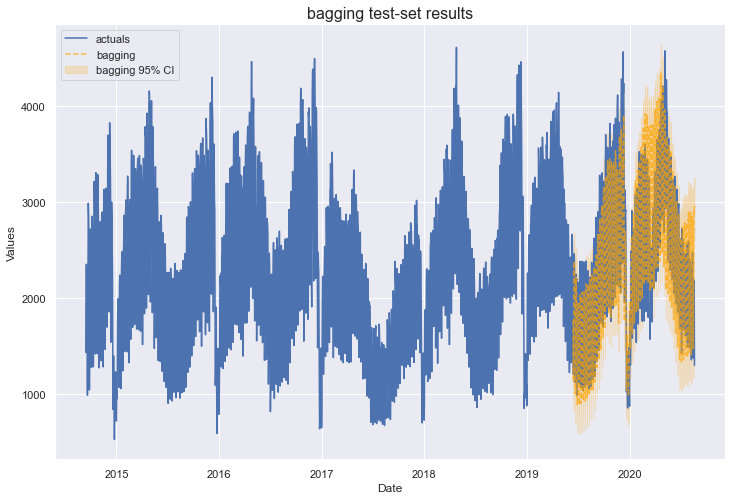

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,bagging,"{'base_estimator': MLPRegressor(hidden_layer_sizes=(100, 100, 100), solver='lbfgs'), 'max_samples': 0.9, 'max_features': 0.5}",0.111060,0.789639,0.056010,0.962499
1,xgboost,"{'n_estimators': 200, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 5, 'subsample': 0.8}",0.113152,0.757755,0.015289,0.997268
2,knn,"{'n_neighbors': 6, 'weights': 'uniform'}",0.115727,0.779783,0.111621,0.871687
3,mlr,{},0.127293,0.770837,0.064186,0.953483
4,lasso,{'alpha': 0.26262626262626265},0.131272,0.774239,0.065229,0.952459
5,elasticnet,"{'alpha': 2, 'l1_ratio': 1}",0.132678,0.764336,0.065361,0.952031
6,ridge,{'alpha': 0.16161616161616163},0.134394,0.769071,0.064234,0.953407
7,lightgbm,"{'n_estimators': 250, 'boosting_type': 'gbdt', 'max_depth': 3, 'learning_rate': 0.1, 'reg_alpha': 0, 'reg_lambda': 0.75, 'num_leaves': 20}",0.135379,0.740025,0.045360,0.974493
8,sgd,"{'penalty': 'elasticnet', 'l1_ratio': 0, 'learning_rate': 'invscaling'}",0.146777,0.730342,0.069495,0.945845
9,rf,"{'max_depth': 5, 'n_estimators': 200, 'max_features': 'log2', 'max_samples': 0.75}",0.187206,0.276690,0.125122,0.853103


In [29]:
plot_test_export_summaries(f)

This is the best-performing model yet, with less overfitting than XGBoost and KNN.

## StackingRegressor
- This model will use the predictions of other models as inputs to a "final estimator". It's added complexity can mean better performance, although not always.

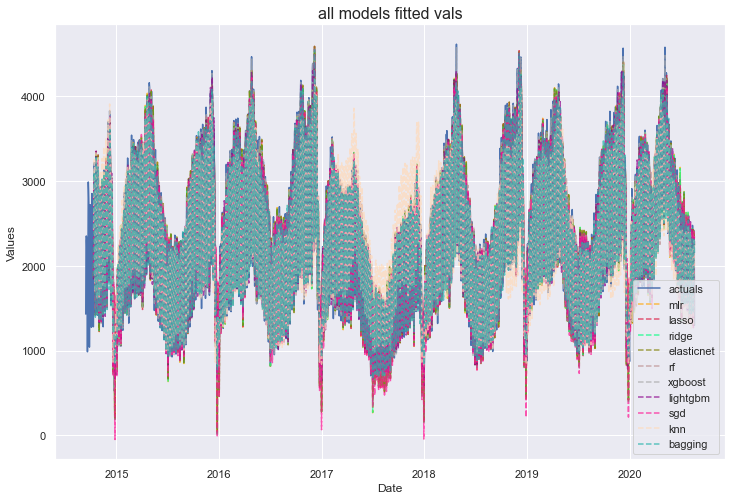

In [30]:
f.plot_fitted()
plt.title('all models fitted vals',size=16)
plt.show()

Sometimes seeing the fitted values can give a good idea of which models to stack, as you want models that can predict both the highs and lows of the series. However, this graph didn't tell us much.  

We use four of our best performing models to create the model inputs. We use a bagging estimator as the final model.  

In [31]:
f.set_estimator('stacking')
results = f.export('model_summaries')
estimators = [
    ('knn',
     KNeighborsRegressor(**results.loc[results['ModelNickname'] == 'knn','HyperParams'].values[0])),
    ('xgboost',
     XGBRegressor(**results.loc[results['ModelNickname'] == 'xgboost','HyperParams'].values[0])),
    ('lightgbm',
     LGBMRegressor(**results.loc[results['ModelNickname'] == 'lightgbm','HyperParams'].values[0])),
    ('sgd',
    SGDRegressor(**results.loc[results['ModelNickname'] == 'sgd','HyperParams'].values[0])),
]

final_estimator = BaggingRegressor(
    base_estimator = MLPRegressor(
        hidden_layer_sizes=(100,100,100),
        solver='lbfgs',
    ),
    max_samples = 0.9,
    max_features = 0.5,
)

f.manual_forecast(
    estimators=estimators,
    final_estimator=final_estimator,
    dynamic_testing=fcst_length
)

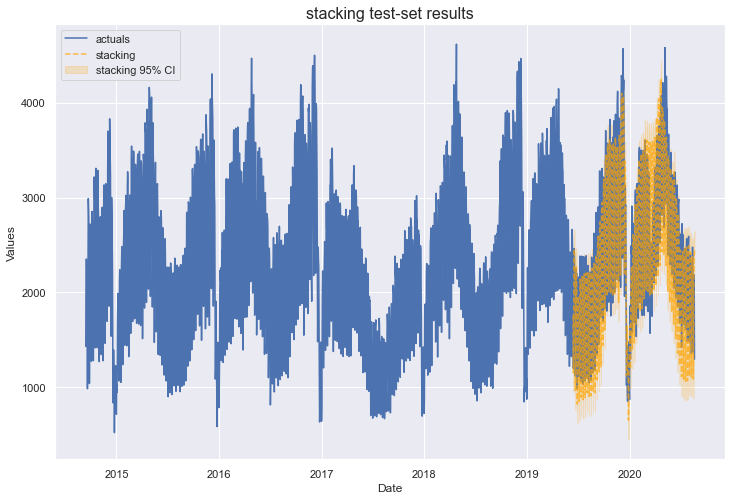

,ModelNickname,HyperParams,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2
0,stacking,"{'estimators': [('knn', KNeighborsRegressor(n_neighbors=6)), ('xgboost', XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, gamma=5, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.1, max_bin=None, max_cat_to_onehot=...",0.098802,0.850544,0.037459,0.982732
1,bagging,"{'base_estimator': MLPRegressor(hidden_layer_sizes=(100, 100, 100), solver='lbfgs'), 'max_samples': 0.9, 'max_features': 0.5}",0.111060,0.789639,0.056010,0.962499
2,xgboost,"{'n_estimators': 200, 'scale_pos_weight': 5, 'learning_rate': 0.1, 'gamma': 5, 'subsample': 0.8}",0.113152,0.757755,0.015289,0.997268
3,knn,"{'n_neighbors': 6, 'weights': 'uniform'}",0.115727,0.779783,0.111621,0.871687
4,mlr,{},0.127293,0.770837,0.064186,0.953483
5,lasso,{'alpha': 0.26262626262626265},0.131272,0.774239,0.065229,0.952459
6,elasticnet,"{'alpha': 2, 'l1_ratio': 1}",0.132678,0.764336,0.065361,0.952031
7,ridge,{'alpha': 0.16161616161616163},0.134394,0.769071,0.064234,0.953407
8,lightgbm,"{'n_estimators': 250, 'boosting_type': 'gbdt', 'max_depth': 3, 'learning_rate': 0.1, 'reg_alpha': 0, 'reg_lambda': 0.75, 'num_leaves': 20}",0.135379,0.740025,0.045360,0.974493
9,sgd,"{'penalty': 'elasticnet', 'l1_ratio': 0, 'learning_rate': 'invscaling'}",0.146777,0.730342,0.069495,0.945845


In [32]:
plot_test_export_summaries(f)

This is our best model with lower amounts of overfitting than some of our other models. We will choose it to make our final forecasts with.

## Backtesting
- Backtesting is an extra step to validate our model's performance. It evaluates the average error over the last n amount of forecast horizons had that particular model been selected to forecast with. Read more about it in the scalecast documentation: https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.backtest

In [33]:
f.backtest('stacking')

View the backtest metrics:

In [34]:
f.export_backtest_metrics('stacking')

,iter1,iter2,iter3,iter4,iter5,iter6,iter7,iter8,iter9,iter10,mean
RMSE,244.644649,193.055257,190.191286,172.873714,169.800014,157.886017,172.29988,172.81879,168.494008,189.208133,183.127175
MAE,174.221535,153.557275,153.386515,141.864459,137.348715,125.223669,140.395108,140.822204,135.556874,159.817941,146.219429
R2,0.656336,0.770783,0.778963,0.831711,0.839722,0.857654,0.832675,0.831645,0.841108,0.803782,0.804438
MAPE,0.085873,0.070166,0.068574,0.065493,0.061324,0.055837,0.06337,0.06412,0.060879,0.07262,0.066826


And the backtest results:

In [35]:
f.export_backtest_values('stacking').head()

,iter1actuals,iter1preds,iter2actuals,iter2preds,iter3actuals,iter3preds,iter4actuals,iter4preds,iter5actuals,iter5preds,iter6actuals,iter6preds,iter7actuals,iter7preds,iter8actuals,iter8preds,iter9actuals,iter9preds,iter10actuals,iter10preds
0,2256,2174.593649,1851,1759.739265,2459,2614.172291,3132,2869.189499,2898,3012.390185,2964,2918.168362,2794,2989.509578,2282,2391.560335,1942,1970.573694,2757,2552.577117
1,2935,2846.556935,2256,2105.611617,1851,1815.034831,2459,2471.030157,3132,2950.051035,2898,2980.060197,2964,3035.020612,2794,3055.306771,2282,2431.150582,1942,1906.404683
2,2950,2867.319472,2935,2848.457815,2256,2138.760624,1851,1773.809261,2459,2520.459585,3132,2926.488556,2898,3012.784238,2964,3001.538692,2794,3068.619909,2282,2387.685454
3,2982,2878.525553,2950,2884.458287,2935,2834.731132,2256,2095.116370,1851,1806.983031,2459,2516.278759,3132,2888.677165,2898,2995.866503,2964,3013.309086,2794,3080.721796
4,2668,2913.551033,2982,2858.457574,2950,2895.388582,2935,2802.843378,2256,2156.210538,1851,1768.669762,2459,2475.454657,3132,2899.714230,2898,3004.550120,2964,3015.689322


## Plot Forecast

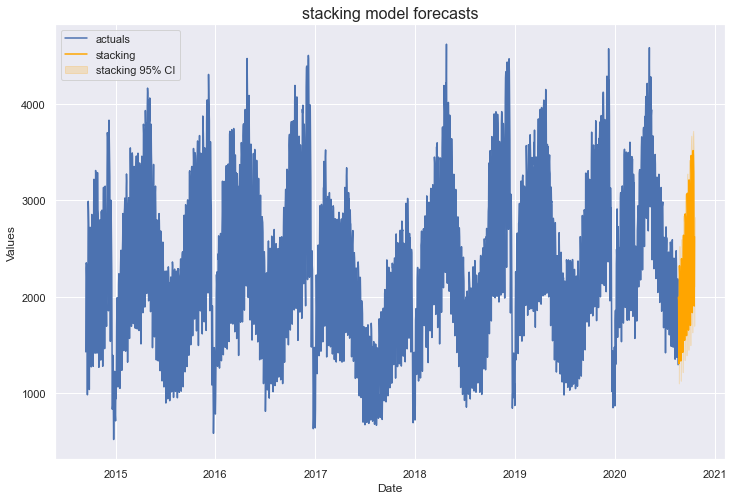

In [36]:
f.plot('stacking',ci=True)
plt.title('stacking model forecasts',size=16)
plt.show()

## View Feature Importance
- uses [eli5](https://eli5.readthedocs.io/en/latest/overview.html) to extract permutation feature importance on each model input

In [37]:
f.save_feature_importance()

In [38]:
f.export_feature_importance('stacking')

,weight,std
feature,,
AR7,0.221579,0.017372
AR28,0.044507,0.001419
dayofweek_5,0.029852,0.006369
AR2,0.023614,0.001522
AR1,0.015183,0.012137
dayofweek_4,0.012377,0.002269
week_2,0.005461,0.000393
dayofweek_1,0.003348,0.000826
week_28,0.001943,0.000434


Many of the model inputs seemed to have actually hurt the model's performance. However, this doesn't mean we should remove each of these features, as each one is tested one at a time, independent of all others. Therefore, removing all negatively performing features could harm the model. We could try removing features one at a time, but without a sound theoretical justification to do so, we might overfit our models. The feature importance can, however, serve to give us insight to which features make our model perform well and help us think more deeply about how to extract accurate forecasts.